In [2]:
import numpy as np
import pandas as pd
import matplotlib
import string
import nltk

#read the training data
df = pd.read_csv('../resources/dataset/dataseer/csv/All2000_for_Patrice_16th_June-xlsx.csv', encoding = "UTF-8")

df.sample(4)

,Journal,Article #,Manuscript ID or DOI,dataset number,Full MeSH data type,Section,Subsection title,Page number,Column number,Data paragraph,Data Keyword,Data action word,Specialist equipment,Notes
9084,SCI REP,1413.0,10.1038/s41598-018-36937-5,5.0,Tabular data,Materials and Methods,NaN,2.0,1.0,Size distribution of the particles and the pol...,Size distribution,were measured,Particle size\nanalyzer Zetasizer Nano ZS (Mal...,NaN
12469,SCI REP,1831.0,https://doi.org/10.1038/s41598-018-37374-0,1.0,Tabular data,Methods,Chlorine mapping analysis,7.0,1.0,The Cl\ncount was measured using a PETH crysta...,Cl count,was measured,NaN,NaN
8985,SCI REP,1398.0,10.1038/s41598-018-36906-y,5.0,Tabular data,Methods,Covariates,3.0,1.0,We selected time-varying demographic variables...,demographic variables,selected,NaN,NaN
4814,PLOS ONE,671.0,https://doi.org/10.1371/journal.pone.0210277,3.0,Electrocardiograph,Methods,Echocardiography,3.0,1.0,The length of the LV at end-diastole (LVEDL) f...,length of the LV at end-diastole,was recorded,NaN,NaN


In [2]:
# check and remove rows with empty text
nb1 = df.shape[0]
df['Data paragraph'].replace('', np.nan, inplace=True)

In [3]:
nb1 = df.shape[0]
df.dropna(subset=['Data paragraph'], inplace=True)
nb2 = df.shape[0]
print(nb1-nb2,"rows with empty paragraph text have been removed")
# df.reset_index(drop=True,inplace=True)

146 rows with empty paragraph text have been removed


In [4]:
# cleaning column types
df = df.astype({"Full MeSH data type": str})
df = df.astype({"Data Keyword": str})
df = df.astype({"Data action word": str})
df = df.astype({"Data paragraph": str})

def clean_fields(row):
    row["Data type"] = row["Full MeSH data type"].strip()
    row["Data Keyword"] = row["Data Keyword"].strip()
    row["Data action word"] = row["Data action word"].strip()
    return row

df = df.apply(clean_fields, axis=1)
datatypes = df['Data type']

# keep the first level
def first_level_filter(val):
    ind = -1
    try:
        ind = val.index(":")
    except:
        pass
    if ind != -1:
        val = val[:ind]
    return val

datatypes = datatypes.map(first_level_filter)
datatypes.head(10)

datatypes = datatypes.value_counts()

print(len(datatypes), "distinct data types")

30 distinct data types


In [5]:
datatypes.head(10)

Tabular data                           9445
Image                                  1522
Spectrometry                            489
Genetic Data                            461
Dataset                                 431
Real-Time Polymerase Chain Reaction     356
Flow cytometry                          221
nan                                     205
Chromatography                          144
Mass Spectrometry                        69
Name: Data type, dtype: int64

In [6]:
datatypes.describe()

count      30.000000
mean      454.366667
std      1724.288689
min         1.000000
25%         4.000000
50%        19.500000
75%       189.750000
max      9445.000000
Name: Data type, dtype: float64

In [7]:
# just to visualize the basic distribution

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

x = datatypes.head(10)
#plot
plt.figure(figsize=(16,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per data type")
plt.ylabel('# of occurrences', fontsize=12)
plt.xlabel('data types ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<Figure size 1600x400 with 1 Axes>

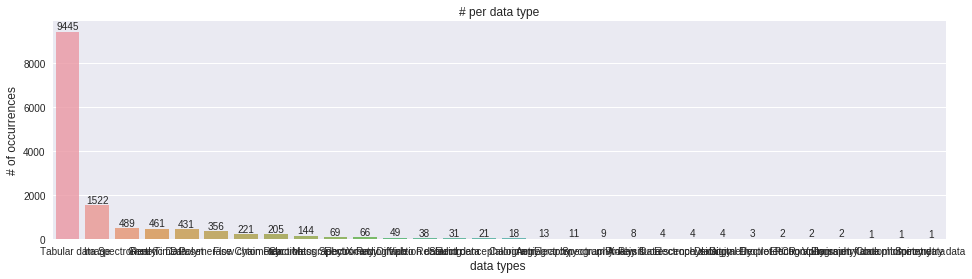

In [8]:
plt.close()

# view long tail
x = datatypes
#plot
plt.figure(figsize=(16,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per data type")
plt.ylabel('# of occurrences', fontsize=12)
plt.xlabel('data types ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [9]:
# data sub-types
datasubtypes = df['Data type']
datasubtypes.head(10)

datasubtypes = datasubtypes.value_counts()

print(len(datasubtypes), "distinct data subtypes")

100 distinct data subtypes


In [10]:
datatypes.describe()

count      30.000000
mean      454.366667
std      1724.288689
min         1.000000
25%         4.000000
50%        19.500000
75%       189.750000
max      9445.000000
Name: Data type, dtype: float64

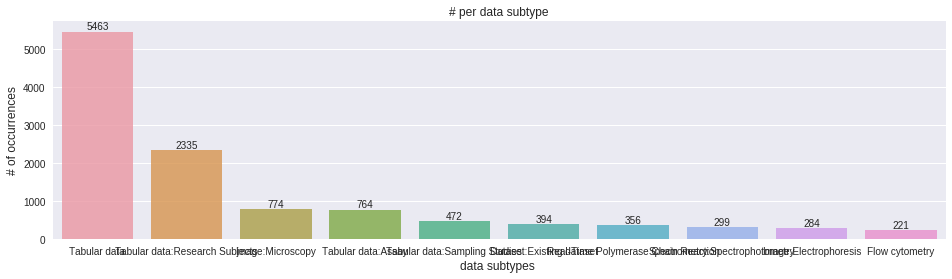

In [11]:
# just to visualize the basic distribution of subtypes

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

x = datasubtypes.head(10)
#plot
plt.figure(figsize=(16,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per data subtype")
plt.ylabel('# of occurrences', fontsize=12)
plt.xlabel('data subtypes ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [12]:
# keep the second level
def second_level_filter(val):
    ind = -1
    subval = None
    try:
        ind = val.index(":")
    except:
        pass
    if ind != -1:
        subval = val[ind+1:]
    return subval

# create a dict of data type and subtypes, to be saved into a json file
datasubtypes = df['Data type']
types = {}
for val in datasubtypes:
    val_type = first_level_filter(val)
    if types.get(val_type) is not None:
        if val_type != val:
            local_val = second_level_filter(val)
            if local_val is not None and not local_val in types.get(val_type):
                types.get(val_type).append(local_val)
    else:
        types[val_type] = []
print(types)

{'Dataset': ['Existing dataset', 'Systematic Review'], 'Electromyography': [], 'Electrooculography': [], 'Image': ['Microscopy', 'Magnetic Resonance Imaging', 'Electrophoresis', 'Tomography, X-Ray Computed', 'Ultrasonography', 'Computerized Tomography scan', 'Magnetic Resonance Imaging:Functional MRI', 'Photography', 'Tomography, Optical Coherence', 'Radiography', 'Diagnostic Imaging'], 'Densitometry': [], 'Spectrum Analysis': [], 'Real-Time Polymerase Chain Reaction': [], 'Spirometry data': [], 'X-Ray fluorescence data': [''], 'Spectrometry': ['Spectrum Analysis, Raman', 'Spectrophotometry', 'Spectrometry, Fluorescence', 'Spectropolarimeter data', 'Spectrometry, Ion Mobility', 'Spectroscopy, Fourier Transform Infrared', 'Nuclear Magnetic Resonance, Biomolecular', 'Spectrophotometry, Atomic', 'Spectrometry, X-Ray Emission', 'Spectroscopy, Photon Correlation', 'X-Ray Absorption Spectroscopy', 'Spectrometry, Force', 'Spectrometry, Time Domain'], 'Mass Spectrometry': ['Liquid Chromatograp

In [13]:
sections = df['Section'].value_counts()
print(len(sections), "distinct section titles")

89 distinct section titles


In [14]:
sections.head(10)

Methods                    6521
Materials and methods      3388
Materials and Methods      1716
Material and methods        479
Material and Methods        317
Method                      187
Methods/design              112
Experimental Procedures      63
Patients and methods         61
Methodology                  57
Name: Section, dtype: int64

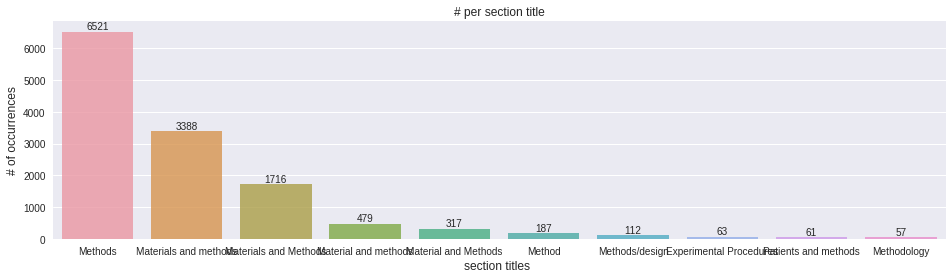

In [15]:
# just to visualize the basic distribution
x = sections.head(10)
#plot
plt.figure(figsize=(16,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per section title")
plt.ylabel('# of occurrences', fontsize=12)
plt.xlabel('section titles ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [16]:
print("Variations in the length of the texts")
lens = df['Data paragraph'].str.len()
print('mean:', lens.mean(), 'std:', lens.std(), 'max:', lens.max())

Variations in the length of the texts
mean: 175.93815567456534 std: 102.73905675650312 max: 1805


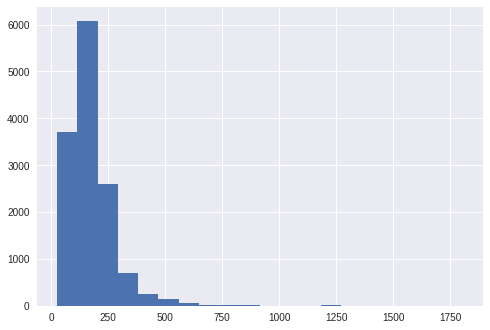

In [17]:
lens.hist(bins=20)

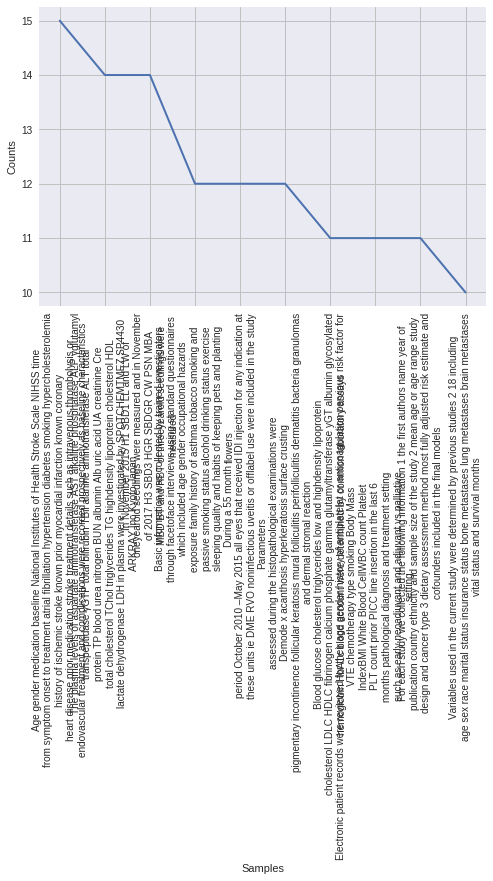

In [18]:
# text duplicates
all_texts = df['Data paragraph']
all_texts = [str(x) for x in all_texts]
sentences = [''.join(c for c in s if c not in string.punctuation) for s in all_texts]
frequency = nltk.FreqDist(sentences)
frequency.plot(10, cumulative = False)

In [19]:
duplicates =0
for key in frequency:
    if frequency[key] > 1:
        duplicates += 1
print(duplicates,"duplicated texts")

1303 duplicated texts


In [20]:
# can we match "Data Keyword" and "Data action word" in "Data paragraph"?
nb_mismatch_data_keyword = 0
nb_mismatch_data_action_word = 0
for i in df.index:
    if df.at[i,"Data paragraph"].find(df.at[i,"Data Keyword"]) == -1:
        nb_mismatch_data_keyword += 1
    if df.at[i,"Data paragraph"].find(df.at[i,"Data action word"]) == -1:
        nb_mismatch_data_action_word += 1
print(nb_mismatch_data_keyword, "mismatched Data keywords out of", df.shape[0])
print(nb_mismatch_data_action_word, "mismatched Data action word out of", df.shape[0])

887 mismatched Data keywords out of 13631
796 mismatched Data action word out of 13631
